<a href="https://colab.research.google.com/github/Euan-J-Austin/Analytics_and_Intelligence/blob/main/Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MATCHING

1. No comparable control group, so create one using individuals and entities.

2. Helps with (self)-selection bias ... sample not representative of the popultion

## How to value Amazon Prime?

Prime is a loyalty program for free shipping, discounts and other services

Aims to: (1) Increase customer loyalty, (2) Increase revenue per customer, (3) decrease marketing spend in customer re-activation, (4) decrease paid advertising in conversion.

### Selection

Those who use Prime and those who don't are different from the start, so they're not comparable.

We need to create a conterfactual control group with characteristics similar to the treatment group.

The matching alogithim will form a control group, selecting from the unmatched those most similar to the treatment group.


## Comparing standardized test scores for Catholic and public schools

Students at both schools have different backgrounds and upbringing so we will need to create a comparable control group.

In [1]:
!pip install CausalInference

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 2.1 MB/s eta 0:00:00


In [4]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as ss
from causalinference import CausalModel

In [6]:
#Data
df = pd.read_csv("/content/school.csv")
df = df.iloc[:,1:]
df.head()

,catholic,race,number_places_lived,mom_age,dad_age,dad_education,mom_education,mom_score,dad_score,income,poverty,food_stamps,score_standardized
0,0,"WHITE, NON-HISPANIC",1,47,45,DOCTORATE OR PROFESSIONAL DEGREE,SOME COLLEGE,53.50,77.5,62500.5,0,0,0.981753
1,0,"WHITE, NON-HISPANIC",1,41,48,BACHELOR'S DEGREE,GRADUATE/PROFESSIONAL SCHOOL-NO DEGREE,34.95,53.5,45000.5,0,0,0.594378
2,0,"WHITE, NON-HISPANIC",1,43,55,"MASTER'S DEGREE (MA, MS)",GRADUATE/PROFESSIONAL SCHOOL-NO DEGREE,63.43,53.5,62500.5,0,0,0.490611
3,1,"WHITE, NON-HISPANIC",1,38,39,BACHELOR'S DEGREE,GRADUATE/PROFESSIONAL SCHOOL-NO DEGREE,53.50,53.5,87500.5,0,0,1.451278
4,0,"WHITE, NON-HISPANIC",1,47,57,DOCTORATE OR PROFESSIONAL DEGREE,"MASTER'S DEGREE (MA, MS)",61.56,77.5,150000.5,0,0,2.595699


## Unconfoundedness

The variables (confounders) used accurately represent the people or entities (W). 

The characteristics affect the likelihood of someone being part of the treatment (X)

The combination of confounders and the treatment leads to the outcome (Y)

The ASSUMPTION of unconfoundedness is a tall order, minimising (self-)selection bias requires great effort ... difficult to allocate metrics to fully represent people

## Data Analysis

### Compring the averages of both groups`


In [7]:
df.groupby('catholic').mean()

<ipython-input-7-f0bef2010b81>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('catholic').mean()


,number_places_lived,mom_age,dad_age,mom_score,dad_score,income,poverty,food_stamps,score_standardized
catholic,,,,,,,,,
0,1.106246,37.794621,40.134919,43.909495,42.590520,65393.928540,0.101578,0.045566,0.163128
1,1.073118,39.775269,42.007527,47.620871,45.908269,86180.625269,0.016129,0.006452,0.219685


### Are the differences between the averages statistically significant?

#### Using the T-Test for continuous variables

In [8]:
#t-test

#Here, and it's most common application, are testing whether the means of two populations are different 

#H0 is the difference between the two means is not statistically significant

#t-test can be used when sample size is more than 30 ... https://stats.stackexchange.com/questions/78961/t-test-for-more-than-30-samples

group1 = df.where(df.catholic == 0).dropna()['income']

group2 = df.where(df.catholic == 1).dropna()['income']

In [9]:
tstat, p = ss.ttest_ind(group1, group2)

print(p)

#so the difference b/w the two groups' income is statistically significant 

5.943636213205364e-41


In [10]:
#can only t-test continuous 

continuous = ['number_places_lived', 'mom_age', 'dad_age', 'mom_score', 'dad_score', 'income']

stat = {}
p = {}

for x in continuous:
  group1 = df.where(df.catholic == 0).dropna()[x]
  group2 = df.where(df.catholic == 1).dropna()[x]
  stat[x], p[x] = ss.ttest_ind(group1, group2)

print(stat)
print(p)

{'number_places_lived': 2.6944305286994696, 'mom_age': -9.824653649822254, 'dad_age': -8.18569031271562, 'mom_score': -9.032982766824812, 'dad_score': -8.672932116270957, 'income': -13.513541496069346}
{'number_places_lived': 0.007072608561784237, 'mom_age': 1.3594922471501544e-22, 'dad_age': 3.344265345899021e-16, 'mom_score': 2.280116071188206e-19, 'dad_score': 5.4897222068833424e-18, 'income': 5.943636213205364e-41}


In [11]:
ttests = pd.DataFrame.from_dict(p, orient = "Index")
ttests.columns = ["pvalue"]
print(ttests)

                           pvalue
number_places_lived  7.072609e-03
mom_age              1.359492e-22
dad_age              3.344265e-16
mom_score            2.280116e-19
dad_score            5.489722e-18
income               5.943636e-41


In [12]:
#The difference between the means of the Catholic and non-Catholic groups are statistically significant

#### Using the Chi-Squared test for binary variables

In [13]:
tab = pd.crosstab(index = df.poverty,
            columns = df.catholic)

tab

catholic,0,1
poverty,,
0,4042,915
1,457,15


In [14]:
stats, p, dof, exp_freq = ss.chi2_contingency(tab)
print(p)

6.511354893726035e-17


In [15]:
#So in relation to the binary variable difference is statistically significant

In [16]:
#what to loop
categorical = ["poverty", "food_stamps"]

#where to store
p = {}

#loop
for y in categorical:
  tab = pd.crosstab(index = df[y],
                  columns = df.catholic)
  stat, p[y], dof, exp = ss.chi2_contingency(tab)
chisquare = pd.DataFrame.from_dict(p, orient = "Index")
chisquare.columns = ["pvalue"]
print(chisquare)

                   pvalue
poverty      6.511355e-17
food_stamps  3.294153e-08


In [17]:
#there exists a close relationship between non-/Catholic and poverty, food stamps so
#the groups are not compatible

### The Curse of Dimensionality

Three variables with three options each, 3^3 gives 27 combinations

Can lead to sacrifcing matching quality, and having too many elements per 'dimension' which leads to misleading outputs

So keep the model simple

#### Transforming the race variable

In [18]:
#Data preparation

In [19]:
dimension = pd.get_dummies(df)
dimension.head(1)

,catholic,number_places_lived,mom_age,dad_age,mom_score,dad_score,income,poverty,food_stamps,score_standardized,...,dad_education_VOC/TECH PROGRAM,mom_education_8TH GRADE OR BELOW,mom_education_9TH - 12TH GRADE,mom_education_BACHELOR'S DEGREE,mom_education_DOCTORATE OR PROFESSIONAL DEGREE,mom_education_GRADUATE/PROFESSIONAL SCHOOL-NO DEGREE,mom_education_HIGH SCHOOL DIPLOMA/EQUIVALENT,"mom_education_MASTER'S DEGREE (MA, MS)",mom_education_SOME COLLEGE,mom_education_VOC/TECH PROGRAM
0,0,1,47,45,53.5,77.5,62500.5,0,0,0.981753,...,0,0,0,0,0,0,0,0,1,0


In [20]:
len(dimension.columns)

#Getting dummies for all categoricl variables gives 37 total columns

37

In [21]:
#Go through each variable case-by-case, starting with race
df.race.value_counts()
#by grouping we can reduce dimensionality e.g. Hispanic

WHITE, NON-HISPANIC                        3654
HISPANIC, RACE NOT SPECIFIED                408
HISPANIC, RACE SPECIFIED                    387
BLACK OR AFRICAN AMERICAN, NON-HISPANIC     357
ASIAN                                       342
MORE THAN ONE RACE, NON HISPANIC            123
NATIVE HAWAIIAN, OTHER PACIFIC ISLANDER      93
AMERICAN INDIAN OR ALASKA NATIVE             62
NOT ASCERTAINED                               3
Name: race, dtype: int64

In [22]:
#White, Hispanic, Black, Asian, Other

df['race_white'] = np.where(df.race == 'WHITE, NON-HISPANIC', 1, 0)
df['race_hispanic'] = np.where((df.race == 'HISPANIC, RACE NOT SPECIFIED') |
(df.race == 'HISPANIC, RACE SPECIFIED'), 1, 0)
df['race_black'] = np.where(df.race == 'BLACK OR AFRICAN AMERICAN, NON-HISPANIC', 1, 0)
df['race_asian'] = np.where(df.race == 'ASIAN', 1, 0)
#df['race_other'] = np.where((df.race == 'MORE THAN ONE RACE, NON HISPANIC') |
#(df.race == 'NATIVE HAWAIIAN, OTHER PACIFIC ISLANDER') | (df.race == 'AMERICAN INDIAN OR ALASKA NATIVE') | (df.race == 'NOT ASCERTAINED')   , 1, 0)

In [23]:
#AVOID THE DUMMY VARIABLE TRAP ... IF WE KNOW NOT W,H,B,A then will be other,
#including other would reduce the prediction models relibility 

#### Transforming the education variable

In [24]:
df.mom_education.value_counts()

SOME COLLEGE                              1721
HIGH SCHOOL DIPLOMA/EQUIVALENT            1306
BACHELOR'S DEGREE                         1085
MASTER'S DEGREE (MA, MS)                   387
VOC/TECH PROGRAM                           294
9TH - 12TH GRADE                           222
GRADUATE/PROFESSIONAL SCHOOL-NO DEGREE     170
8TH GRADE OR BELOW                         134
DOCTORATE OR PROFESSIONAL DEGREE           110
Name: mom_education, dtype: int64

In [26]:
#Transforming education variable
df["dad_higher_education"] = np.where((df.dad_education == "BACHELOR'S DEGREE") |
                                      (df.dad_education == "MASTER'S DEGREE (MA, MS)") |
                                      (df.dad_education == "DOCTORATE OR PROFESSIONAL DEGREE"),
                                      1, 0)
df["mom_higher_education"] = np.where((df.mom_education == "BACHELOR'S DEGREE") |
                                      (df.mom_education == "MASTER'S DEGREE (MA, MS)") |
                                      (df.mom_education == "DOCTORATE OR PROFESSIONAL DEGREE"),
                                      1, 0)

In [34]:
df.head(1)

,catholic,number_places_lived,mom_age,dad_age,mom_score,dad_score,income,poverty,food_stamps,score_standardized,race_white,race_hispanic,race_black,race_asian,dad_higher_education,mom_higher_education
0,0,1,47,45,53.5,77.5,62500.5,0,0,0.981753,1,0,0,0,1,0


In [ ]:
#Clean the data frame
df =  df.drop(columns = ['race', 'dad_education', 'mom_education'])

In [35]:
#Isolate confounders, treat, y
treat = df.catholic.values
y = df.score_standardized.values
confounders = df.drop(columns = ['catholic', 'score_standardized']).values

#### How to determine the Common Support Region?

Good matching if elements in treated and confounders are similar enough

PLot density curves for probability of treated and non-treated groups being treated, there should be overlap between the two curves ... this is the Common Support Region



In [36]:
 #1 list of confounders
 #2 logisitic regression
 #3 visualise probabilities

 #Logistic regression

 import statsmodels.api as sm 

In [37]:
confounders_csr = sm.add_constant(confounders)

In [38]:
csr_model = sm.Logit(treat, confounders_csr).fit()

Optimization terminated successfully.
         Current function value: 0.430983
         Iterations 8


In [39]:
csr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 5429
Model:                          Logit   Df Residuals:                     5414
Method:                           MLE   Df Model:                           14
Date:                Sun, 11 Jun 2023   Pseudo R-squ.:                 0.05888
Time:                        16:52:56   Log-Likelihood:                -2339.8
converged:                       True   LL-Null:                       -2486.2
Covariance Type:            nonrobust   LLR p-value:                 3.835e-54
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.3412      0.418    -10.380      0.000      -5.161      -3.521
x1            -0.1666      0.124     -1.341      0.180      -0.410       0.077
x2             0.0292      0.010      2.860      0.004       0.009       0.049
x3             0.0122      0.009      1.390      0.165      -0.005       0.029
x4             0.0074      0.004      2.089      0.037       0.000       0.014
x5             0.0065      0.004      1.706      0.088      -0.001       0.014
x6          5.171e-06   9.59e-07      5.392      0.000    3.29e-06    7.05e-06
x7            -1.1431      0.278     -4.105      0.000      -1.689      -0.597
x8            -0.9002      0.430     -2.095      0.036      -1.742      -0.058
x9             0.3749      0.198      1.893      0.058      -0.013       0.763
x10            0.4315      0.221      1.951      0.051      -0.002       0.865
x11           -0.0920      0.267     -0.345      0.730      -0.615       0.431
x12           -0.1121      0.256     -0.438      0.661      -0.614       0.390
x13           -0.0585      0.096     -0.611      0.541      -0.246       0.129
x14            0.1881      0.093      2.012      0.044       0.005       0.371
==============================================================================
"""

In [40]:
probabilities = csr_model.predict(confounders_csr)
probabilities

array([0.26041384, 0.17273291, 0.24596599, ..., 0.23182116, 0.12192314,
       0.1825144 ])

In [41]:
 #build object with treat and probabilities 

df_prob = np.vstack([treat, probabilities])
df_prob

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.26041384, 0.17273291, 0.24596599, ..., 0.23182116, 0.12192314,
        0.1825144 ]])

In [42]:
df_prob = np.transpose(df_prob)
df_prob

array([[0.        , 0.26041384],
       [0.        , 0.17273291],
       [0.        , 0.24596599],
       ...,
       [0.        , 0.23182116],
       [0.        , 0.12192314],
       [0.        , 0.1825144 ]])

In [43]:
#Split between treated and non-treated
non_treated = df_prob[:,0] == 0 
non_treated

array([ True,  True,  True, ...,  True,  True,  True])

In [44]:
non_treated = df_prob[non_treated, 1]
non_treated

array([0.26041384, 0.17273291, 0.24596599, ..., 0.23182116, 0.12192314,
       0.1825144 ])

In [ ]:
treated = df_prob[:,0] == 1
treated = df_prob[treated, 1]
treated

<ipython-input-47-25b12e123977>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(non_treated, shade = True, color = 'red')
<ipython-input-47-25b12e123977>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(treated, shade = True, color = 'blue')


<Axes: ylabel='Density'>

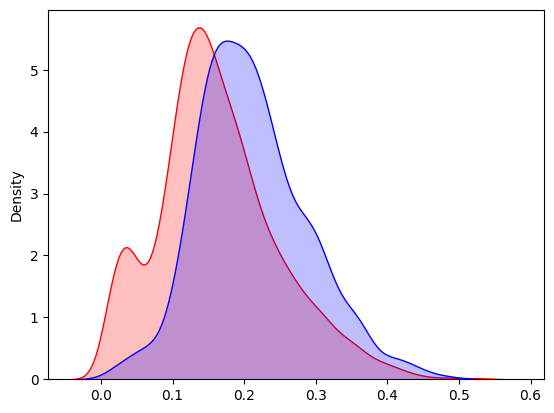

In [47]:
#plot CSR

sns.kdeplot(non_treated, shade = True, color = 'red')
sns.kdeplot(treated, shade = True, color = 'blue')

#### Matching Model

In [49]:
model = CausalModel(y, treat, confounders)
model.est_via_matching(bias_adj = True)
print(model.estimates)

/usr/local/lib/python3.10/dist-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef



Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.133      0.065     -2.044      0.041     -0.260     -0.005
           ATC     -0.126      0.073     -1.737      0.082     -0.268      0.016
           ATT     -0.167      0.060     -2.786      0.005     -0.284     -0.049



ATT is the average treatment effect, ATT is the average treatment effect on the treated e.g. ATT tells us how much a soldier gained or lost from service, ATE how much a typical application gained or lost. So we will use the ATE as we want to know the effect of Catholic school for all potential students. Our ATE score would suggest standardized test scores are 13.3% lower for Catholic school students.

#### Robustness checks

1. Repeat experiment process multiple times ... Dataset --> Sample --> Subsample --> Matching --> Store Results

2. Repeat this process ... Variables --> Remove 1 --> Matching --> Store results

In [52]:
#Robust check -- repeated samples

#isolate the coef
model.estimates['matching']['ate']

-0.13297192873362434

In [ ]:
ate = {}
i = 0

while i < 1000:
  #sampling
  sample = df.sample(1000)
  #isolation of treat, y and confounders
  treat = sample.catholic.values
  y = sample.score_standardized.values
  confounders = sample.drop(columns = ['catholic', 
                                       'score_standardized']).values
  #matching model
  model = CausalModel(y, treat, confounders)
  model.est_via_matching(bias_adj = True)
  #store results
  ate[i] = model.estimates['matching']['ate']
  i += 1

Axes(0.125,0.11;0.775x0.77)
-0.1269595182037932


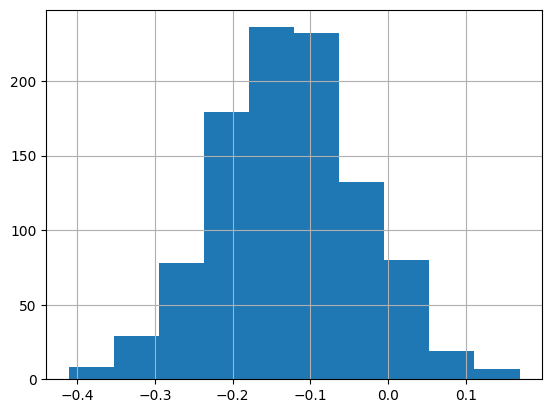

In [56]:
ate = pd.Series(ate)
print(ate.hist())
print(ate.mean())

In [57]:
#Robustness check -- removing 1 confounder
#we expect that removing one confounding variable will not have a great impact otherwise that would suggest our matching is faulty
df.columns

Index(['catholic', 'number_places_lived', 'mom_age', 'dad_age', 'mom_score',
       'dad_score', 'income', 'poverty', 'food_stamps', 'score_standardized',
       'race_white', 'race_hispanic', 'race_black', 'race_asian',
       'dad_higher_education', 'mom_higher_education'],
      dtype='object')

In [58]:
#Robustness check -- removing 1 confounder
treat = sample.catholic.values
y = sample.score_standardized.values
confounders = sample.drop(columns = ['catholic', 
                                     'score_standardized',
                                     'number_places_lived']).values
model = CausalModel(y, treat, confounders)
model.est_via_matching(bias_adj = True)
print(model.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.171      0.126     -1.350      0.177     -0.418      0.077
           ATC     -0.157      0.140     -1.124      0.261     -0.431      0.117
           ATT     -0.231      0.129     -1.798      0.072     -0.483      0.021



/usr/local/lib/python3.10/dist-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef
